In [0]:

import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.datasets import FashionMNIST
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

gpu = 0

In [0]:
class ConvCaps2D(nn.Module):
    def __init__(self):
        super(ConvCaps2D, self).__init__()
        # 32 8D capsules
        self.capsules = nn.ModuleList([nn.Conv2d(in_channels = 512, out_channels = 8, kernel_size=9, stride=2)
                                       for _ in range(32)])
        
    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm) # scale.size()  is (None, 1152, 1)  
        return scale*tensor / torch.sqrt(norm)
        
    def forward(self, x):
        outputs = [capsule(x).view(x.size(0), 8, -1) for capsule in self.capsules] # 32 list of (None, 1, 8, 36)
        outputs = torch.cat(outputs, dim = 2).permute(0, 2, 1)  # outputs.size() is (None, 1152, 8)
        return self.squash(outputs)

In [0]:

class Caps1D(nn.Module):
    def __init__(self):
        super(Caps1D, self).__init__()
        self.num_caps = 10
        self.num_iterations = 10
        self.W = nn.Parameter(torch.randn(10, 1152, 8, 16))
        
    def softmax(self, x, dim = 1):
        transposed_input = x.transpose(dim, len(x.size()) - 1)
        softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)))
        return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(x.size()) - 1)

    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm)        
        return scale*tensor / torch.sqrt(norm)
   
    # Routing algorithm
    def forward(self, u):
        # u.size() is (None, 1152, 8)
        '''
        tensor1 is a j x 1 x n x m Tensor and tensor2 is a k x m x p Tensor, 
        out will be an j x k x n x p Tensor.
        
        So j = None, 1, n = 1152, k = 10, m = 8, p = 16
        '''
        
        u_ji = torch.matmul(u[:, None, :, None, :], self.W) # u_ji.size() is (None, 10, 1152, 1, 16)
        
        b = Variable(torch.zeros(u_ji.size())).cuda(gpu) # b.size() is (None, 10, 1152, 1, 16)
        
        for i in range(self.num_iterations):
            c = self.softmax(b, dim=2)
            v = self.squash((c * u_ji).sum(dim=2, keepdim=True)) # v.size() is (None, 10, 1, 1, 16)

            if i != self.num_iterations - 1:
                delta_b = (u_ji * v).sum(dim=-1, keepdim=True)
                b = b + delta_b
        
        #computing the length of the vectors and softmax is used to get probability.
        v = v.squeeze()
        classes = (v ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes) 
        
        return classes
net = Caps1D().cuda(gpu)
# sum(net.forward(Variable(torch.Tensor(np.random.rand(1, 1152, 8)).cuda(gpu))))

In [0]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 512, kernel_size = 9, stride = 1)
        
        self.primaryCaps = ConvCaps2D()
        self.digitCaps = Caps1D()
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        
        return x

net = CapsNet().cuda(gpu)
# out = net.forward(Variable(torch.from_numpy(np.random.rand(32, 1, 28, 28).astype('float32')).cuda(gpu)))

In [0]:

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters())

In [0]:
def evaluate(model, X, Y, batch_size = 50):
    results = []
    predicted = []
    
    for i in range(len(X)//batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]).cuda(gpu))
        pred = model(inputs)
        
        predicted += list(np.argmax(pred.data.cpu().numpy(), axis = 1))
        
    acc = sum(Y == predicted)*1.0/(len(Y))
    return acc

In [7]:

dataset = FashionMNIST(root='./data', download=True, train=True)

X_train = np.expand_dims(getattr(dataset, 'train_data').numpy().astype('float32'), 1)/255.0
y_train = getattr(dataset, 'train_labels').numpy().astype('int64')

indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

dataset = FashionMNIST(root='./data', download=True, train=False)

X_test = np.expand_dims(getattr(dataset, 'test_data').numpy().astype('float32'), 1)/255.0
y_test = getattr(dataset, 'test_labels').numpy().astype('int64')

indices = np.random.permutation(len(X_test))
X_test = X_test[indices]
y_test = y_test[indices]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision

In [0]:

import matplotlib
import matplotlib.pyplot as plt

def plot_images(images):
    "Plot images separately."
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

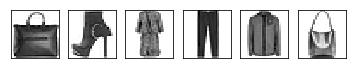

In [9]:

plot_images(X_train[:6,0])

In [13]:
batch_size = 200
epochs = 10 

trn_acc = []
tst_acc = []
trn_loss = []

for epoch in range(epochs):  
    print ("\nEpoch ", epoch)
    
    running_loss = 0.0
    #print ("Mini-batch : ",)
    for i in range(len(X_train)//batch_size):
        #print  (i), 
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.LongTensor(np.array(y_train[s:e]))
                
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda(gpu)), Variable(labels.cuda(gpu))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()
        
        del inputs, labels
    
    # Training Info
    trn_loss.append(running_loss)
    trn_acc.append(evaluate(net, X_train, y_train, batch_size = 200))
    tst_acc.append(evaluate(net, X_test, y_test, 200)) 
    
    print ("Epoch, Loss - {}, {}".format(epoch, running_loss)) 
    print ("Train - ", trn_acc[-1])
    print ("Test - ", tst_acc[-1])


Epoch  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch, Loss - 0, 690.0815644264221
Train -  0.4902
Test -  0.4823

Epoch  1
Epoch, Loss - 1, 666.6525819301605
Train -  0.7662833333333333
Test -  0.7527

Epoch  2
Epoch, Loss - 2, 659.3021292686462
Train -  0.8136666666666666
Test -  0.7994

Epoch  3
Epoch, Loss - 3, 658.112312078476
Train -  0.8162666666666667
Test -  0.8038

Epoch  4
Epoch, Loss - 4, 657.535941362381
Train -  0.8296
Test -  0.817

Epoch  5
Epoch, Loss - 5, 657.1288068294525
Train -  0.82225
Test -  0.8141

Epoch  6
Epoch, Loss - 6, 656.9661290645599
Train -  0.8345
Test -  0.8225

Epoch  7
Epoch, Loss - 7, 656.6637725830078
Train -  0.8518833333333333
Test -  0.8409

Epoch  8
Epoch, Loss - 8, 656.6176609992981
Train -  0.8644666666666667
Test -  0.8536

Epoch  9
Epoch, Loss - 9, 656.2963321208954
Train -  0.8635166666666667
Test -  0.85


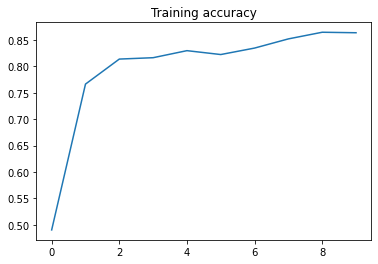

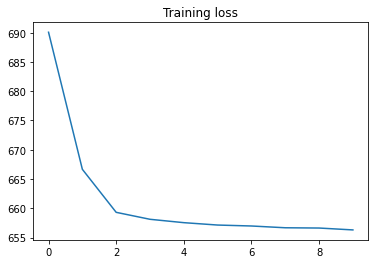

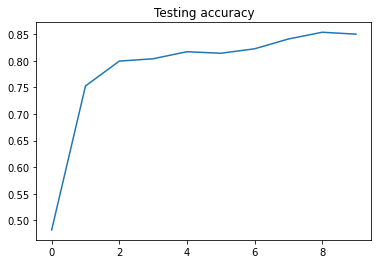

In [14]:
plt.plot(range(0, epochs), trn_acc)
plt.title('Training accuracy')
plt.show()

plt.plot(range(0, epochs), trn_loss)
plt.title('Training loss')
plt.show()

plt.plot(range(0, epochs), tst_acc)
plt.title('Testing accuracy')
plt.show()